# How to deploy Black Forest Labs's BnB 4-bit quantized FLUX.1 model for inference on Amazon SageMakerAI

In this notebook, you will learn how to deploy **Black Forest Labs's FLUX.1-dev-bnb-4bit** model based on [Black Forest Labs's FLUX.1-dev](black-forest-labs/FLUX.1-dev) model.(HuggingFace model ID [diffusers/FLUX.1-dev-bnb-4bit](https://huggingface.co/diffusers/FLUX.1-dev-bnb-4bit): using Amazon SageMaker AI. The inference image will be the SageMaker-managed [LMI (Large Model Inference) v15](https://docs.aws.amazon.com/sagemaker/latest/dg/large-model-inference-container-docs.html) Docker image. LMI images features a [DJL serving](https://github.com/deepjavalibrary/djl-serving) stack powered by the [Deep Java Library](https://djl.ai/). 

FLUX.1 [dev] is a 12 billion parameter rectified flow transformer capable of generating images from text descriptions. For more information, please read [blog post](https://bfl.ai/blog/24-08-01-bfl).

### Key Features

- The FLUX.1-dev-bnb-4bit model is a 4-bit quantized version of the FLUX.1-dev image generation model, optimized for efficiency on consumer-grade hardware
- BitsAndBytes (bnb) quantization: The model uses the popular BitsAndBytes library, which enables developers to load and run it easily with a few lines of code using the diffusers library
- Reduced hardware requirements: This model is designed to run efficiently on GPUs with less than 12 GB of VRAM, making it accessible to a wider range of users with less expensive hardware.
- Faster inference: The 4-bit quantization allows for quicker image generation compared to the original higher-precision model. This trade-off between quality and speed makes it ideal for users who need faster iteration times.

### Usage

We provide a reference implementation of FLUX.1 [BnB 4-bit], as well as sampling code, in a dedicated github repository. Developers and creatives looking to build on top of FLUX.1 [BnB 4-bit] are encouraged to use this as a starting point.

### Out-of-Scope Use 
The model and its derivatives may not be used

- In any way that violates any applicable national, federal, state, local or international law or regulation.
- For the purpose of exploiting, harming or attempting to exploit or harm minors in any way; including but not limited to the solicitation, creation, acquisition, or dissemination of child exploitative content.
- To generate or disseminate verifiably false information and/or content with the purpose of harming others.
- To generate or disseminate personal identifiable information that can be used to harm an individual.
- To harass, abuse, threaten, stalk, or bully individuals or groups of individuals.
- To create non-consensual nudity or illegal pornographic content.
- For fully automated decision making that adversely impacts an individual's legal rights or otherwise creates or modifies a binding, enforceable obligation.
- Generating or facilitating large-scale disinformation campaigns.


### License agreement
* This model is open source on HuggingFace, please refer to the original [model card](https://huggingface.co/diffusers/FLUX.1-dev-bnb-4bit)
* This notebook is a sample notebook and not intended for production use.

## Payload format to invoke the model


Below you can find an examples for a request. 

```python
{
    "prompt": "A cat holding a sign that says hello world",
    "guidance_scale": 0.0,
    "num_inference_steps": 4,
    "max_sequence_length": 256,
    "seed": 42
}
```



In [ ]:
%pip install -r requirements.txt --quiet --no-warn-conflicts

In [1]:
import sagemaker
import boto3
import logging
import time
from sagemaker.session import Session
from sagemaker.s3 import S3Uploader

print(sagemaker.__version__)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
2.256.0


In [2]:
try:
    boto_region = boto3.Session().region_name
    sm_session = sagemaker.session.Session(boto_session=boto3.Session(region_name=boto_region))
    role = sagemaker.get_execution_role()
    sagemaker_default_bucket = sm_session.default_bucket()
    
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

print(f"sagemaker role arn: {role}")
print(f"sagemaker default bucket: {sagemaker_default_bucket}")

sagemaker role arn: arn:aws:iam::992382683940:role/amazon-sagemaker-base-executionrole
sagemaker default bucket: sagemaker-us-west-2-992382683940


In [3]:
HF_MODEL_ID = "diffusers/FLUX.1-dev-bnb-4bit"

base_name = HF_MODEL_ID.split('/')[-1].replace('.', '-').lower()
model_lineage = HF_MODEL_ID.split("/")[0]
base_name

'flux-1-dev-bnb-4bit'

## Download the model from Hugging Face and upload the model artifacts on Amazon S3
If you are deploying a model hosted on the HuggingFace Hub, you must specify the `option.model_id=<hf_hub_model_id>` configuration. When using a model directly from the hub, we recommend you also specify the model revision (commit hash or branch) via `option.revision=<commit hash/branch>`. *Here we are using the env variable during deployment instead of serving.properties file*

Since model artifacts are downloaded at runtime from the Hub, using a specific revision ensures you are using a model compatible with package versions in the runtime environment. Open Source model artifacts on the hub are subject to change at any time. These changes may cause issues when instantiating the model (updated model artifacts may require a newer version of a dependency than what is bundled in the container). If a model provides custom model (modeling.py) and/or custom tokenizer (tokenizer.py) files, you need to specify option.trust_remote_code=true to load and use the model.

In this example, we will demonstrate how to download your copy of the model from huggingface and upload it to an s3 location in your AWS account, then deploy the model with the downloaded model artifacts to an endpoint.  

**Best Practices**:
>
> **Store Models in Your Own S3 Bucket**
For production use-cases, always download and store model files in your own S3 bucket to ensure validated artifacts. This provides verified provenance, improved access control, consistent availability, protection against upstream changes, and compliance with organizational security protocols.
>

In [4]:
from huggingface_hub import snapshot_download
from pathlib import Path
from transformers import AutoModel
import torch

model_dir = Path('model-files')
model_dir.mkdir(exist_ok=True)

snapshot_download(HF_MODEL_ID, local_dir=model_dir)


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/566 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/672 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

text_encoder_2/model-00001-of-00002.safe(…):   0%|          | 0.00/4.90G [00:00<?, ?B/s]

text_encoder_2/model-00002-of-00002.safe(…):   0%|          | 0.00/1.43G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/930 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_2/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

transformer/diffusion_pytorch_model.safe(…):   0%|          | 0.00/6.70G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

'/home/sagemaker-user/sagemaker-genai-hosting-examples/workshop/inference/lab4/Image Generation/model-files'

### Configure model.py and requirements.txt that will be used to load the model

**Best Practices**:
>
> **Note**: When your model and configuration files are in different S3 locations, set `option.model_id=<s3_model_uri>` in your serving.properties file, where `s3_model_uri` is the S3 object prefix containing your model artifacts. SageMaker AI will automatically download the model files by looking at the S3URI in model_id
>*Here we are using the env variable during deployment instead of serving.properties file*

In [5]:
%%writefile ./model-files/model.py
import torch
from diffusers import FluxPipeline
import base64
from io import BytesIO
from djl_python import Input, Output
import os

class FluxModelHandler(object):
    def __init__(self):
        self.pipe = None
        self.device = None
        # Initialize the model immediately when the class is instantiated
        self._load_model()

    def _load_model(self):
        """Load the model once during container startup"""
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")
    
        # Use the "/opt/ml/model" location
        model_path = "/opt/ml/model"
     
        if model_path:
            print(f"Loading model from DJL download location: {model_path}")
            self.pipe = FluxPipeline.from_pretrained(model_path, torch_dtype=torch.bfloat16)
        else:
            raise FileNotFoundError("Model not found, please make sure the model files are downloaded from s3")
    
        if self.device == "cuda":
            self.pipe.enable_model_cpu_offload()
        
        print("Model loaded successfully and ready for inference!")

    def handle(self, inputs: Input) -> Output:
        # Model is already loaded, no need to check initialization
        try:
            input_data = inputs.get_as_json()
            prompt = input_data.get("prompt", "A cat holding a sign that says hello world")
            guidance_scale = float(input_data.get("guidance_scale", 0.0))
            num_inference_steps = int(input_data.get("num_inference_steps", 4))
            max_sequence_length = int(input_data.get("max_sequence_length", 256))
            seed = int(input_data.get("seed", 0))

            generator = torch.Generator(self.device).manual_seed(seed)

            image = self.pipe(
                prompt,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                max_sequence_length=max_sequence_length,
                generator=generator
            ).images[0]

            # Convert to base64
            buffered = BytesIO()
            image.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode()

            output = Output()
            output.add_as_json({"generated_image": img_str})
            return output

        except Exception as e:
            error_output = Output()
            error_output.add_as_json({"error": str(e)})
            return error_output


# Create the service instance once when the module is imported
_service = FluxModelHandler()


def handle(inputs: Input) -> Output:
    return _service.handle(inputs)

Writing ./model-files/model.py


In [6]:
%%writefile ./model-files/requirements.txt
peft==0.15.1
diffusers==0.34.0
transformers>=4.46.0
transformers[sentencepiece]
accelerate==1.0.1
pillow==11.2.1
bitsandbytes==0.47.0

Writing ./model-files/requirements.txt


### Upload model files to S3 in uncompress format for SageMaker AI
SageMaker AI allows us to provide [uncompressed](https://docs.aws.amazon.com/sagemaker/latest/dg/large-model-inference-uncompressed.html) files. Thus, we directly upload the folder that contains model files to s3
> **Note**: The default SageMaker bucket follows the naming pattern: `sagemaker-{region}-{account-id}`

> ⚠️ **Important**: 
> - Uploading to s3 can take approximately 5 minutes. Please ensure this step completes


In [7]:
# upload uncompress model files to s3
model_artifact_uri = S3Uploader.upload(
    local_path="./model-files",
    desired_s3_uri=f"s3://{sagemaker_default_bucket}/lmi/{base_name}"
)
print(f"Model files are uploaded to --- >: {model_artifact_uri}")

Model files are uploaded to --- >: s3://sagemaker-us-west-2-992382683940/lmi/flux-1-dev-bnb-4bit


In [8]:
!rm -rf ./model-files

## Configure Model Container and Instance

For deploying FLUX.1-dev-bnb-4bit model, we'll use:
- **LMI (Deep Java Library) Inference Container**: A container optimized for large language model inference
- **[G5 Instance](https://aws.amazon.com/ec2/instance-types/g5/)**: High performance GPU-based instances for graphics-intensive applications and machine learning inference

Key configurations:
- The container URI points to the DJL inference container in ECR (Elastic Container Registry)
- We use `ml.g5.4xlarge` instance
> **Note**: The region in the container URI should match your AWS region.

In [9]:
CONTAINER_VERSION = '0.33.0-lmi15.0.0-cu128'
image_uri = "763104351884.dkr.ecr.{}.amazonaws.com/djl-inference:{}".format(sm_session.boto_session.region_name, CONTAINER_VERSION)
print(image_uri)

763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.33.0-lmi15.0.0-cu128


In [10]:
gpu_instance_type = "ml.g5.4xlarge"

## Create SageMaker Model

Now we'll create a SageMaker Model object that combines our:
- Container image (LMI)
- model artifacts (model files + config files)
- IAM role (for permissions)

In [11]:
# Specify the S3 URI for your uncompressed config files
config_data = {
    "S3DataSource": {
        "S3Uri": f"{model_artifact_uri}/",
        "S3DataType": "S3Prefix",
        "CompressionType": "None"
    }
}

> **Note**: Here S3 URI points to the configuration files S3 location

In [12]:
from sagemaker.utils import name_from_base
from sagemaker.model import Model

model_name = name_from_base(base_name, short=True)

# Create model
black_forest_model = Model(
    name=model_name,
    image_uri=image_uri,
    model_data=config_data,  # Path to your model files
    role=role,
    env={
        "HF_TASK": "text-to-image",
        "SERVING_FAIL_FAST": "true",
        "OPTION_MODEL_ID": "/opt/ml/model",
        "OPTION_ASYNC_MODE": "false",
        "OPTION_ROLLING_BATCH": "disable",
        "OPTION_TENSOR_PARALLEL_DEGREE": "max",
        "OPTION_TRUST_REMOTE_CODE": "true",
        "OPTION_ENTRYPOINT": "model.py",
        "OPTION_DTYPE": "bfloat16",
    },
    sagemaker_session=sm_session
)

## Deploy Model to SageMaker Endpoint

Now we'll deploy our model to a SageMaker endpoint for real-time inference. 
> ⚠️ **Important**: 
> - Deployment can take up to 15 minutes
> - Monitor the CloudWatch logs for progress

In [13]:
%%time

from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(base_name, short=True)
instance_type = gpu_instance_type
print(endpoint_name)

black_forest_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)


flux-1-dev-bnb-4bit-260121-2022
-----------!CPU times: user 133 ms, sys: 22.9 ms, total: 156 ms
Wall time: 6min 3s


### Create a predictor from our existing endpoint and make inference

In [14]:
%%time

from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor


predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    sagemaker_session=sm_session
)

CPU times: user 25 μs, sys: 21 μs, total: 46 μs
Wall time: 48.6 μs


In [15]:
import json

# Make a prediction
payload = {
    "prompt": "whimsical and ethereal soft-shaded story illustration: A woman in a large hat stands at the ship's railing looking out across the ocean",
    "guidance_scale": 0.0,
    "num_inference_steps": 30,
    "max_sequence_length": 256,
    "seed": 42
}

response = predictor.predict(payload)

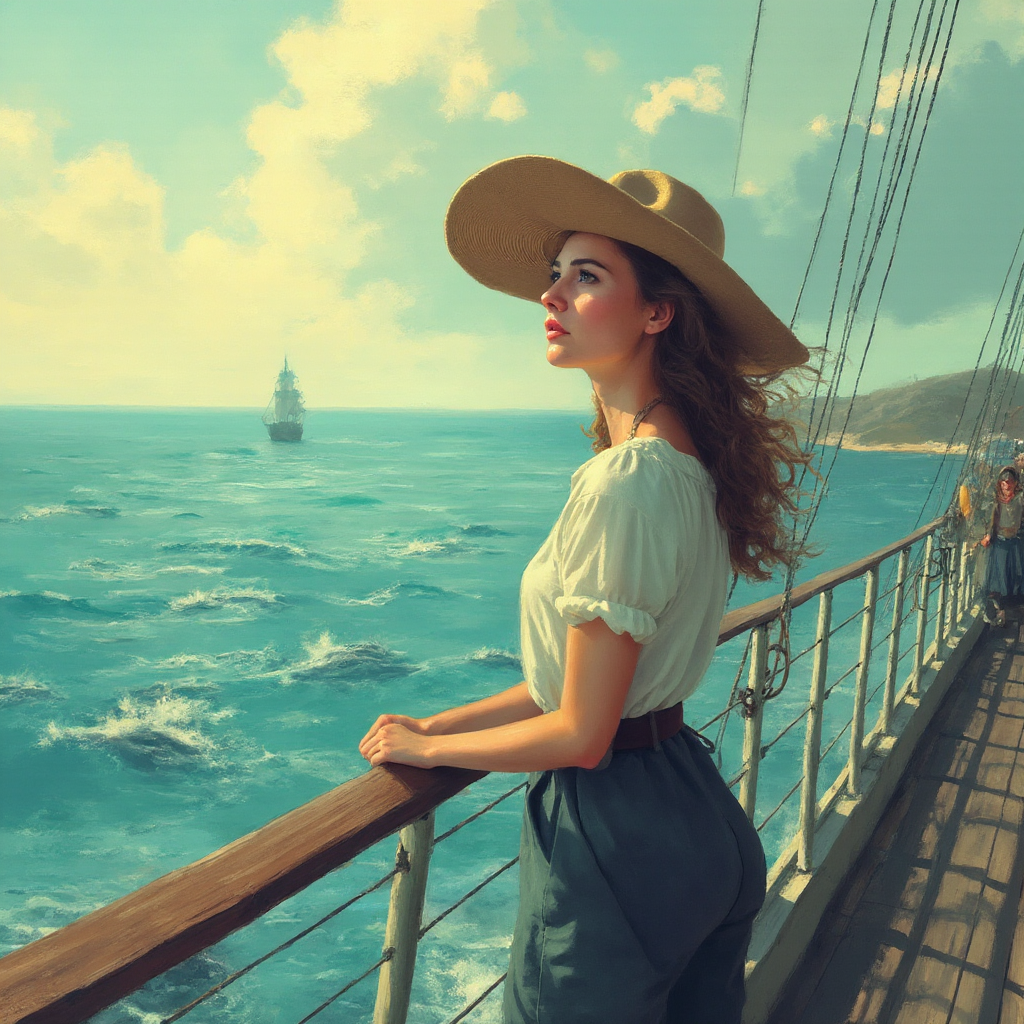

In [16]:
# If you want to convert the base64 image back to a PIL Image:
import base64
from PIL import Image
import io

# Extract the base64-encoded image data from the response
base64_image = response['generated_image']

# Decode the base64 string to bytes
image_bytes = base64.b64decode(base64_image)

# Create a PIL Image from the bytes
generated_image = Image.open(io.BytesIO(image_bytes))

# Display the image (this will open in your default image viewer)
generated_image.show()

# Save the image to a file
generated_image.save('generated_image.png')

### Inference using boto3

In [17]:
import boto3
import json
import base64
from PIL import Image
import io

endpoint_name = endpoint_name
prompt = "A cat holding a sign that says hello world"

def test_endpoint(endpoint_name, prompt):
    runtime = boto3.client('sagemaker-runtime', region_name=boto_region)
    
    # Prepare the payload
    payload = {
        "prompt": prompt,
        "guidance_scale": 0.0,
        "num_inference_steps": 32,
        "max_sequence_length": 256,
        "seed": 42
    }
    
    try:
        response = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='application/json',
            Body=json.dumps(payload)
        )
        
        result = json.loads(response['Body'].read())
        print("Success!")
        return result
    except Exception as e:
        print(f"Error: {str(e)}")
        raise


In [18]:
# Test the endpoint
response = test_endpoint(endpoint_name, prompt)

Success!


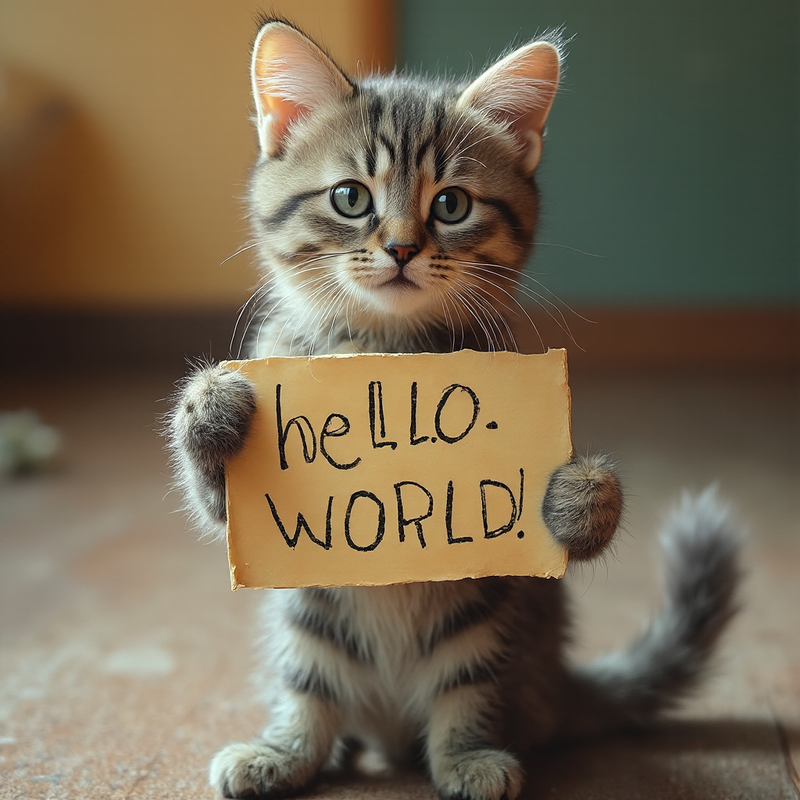

In [19]:
import base64
from PIL import Image
from IPython.display import display
import io

# Extract the base64-encoded image data from the response
base64_image = response['generated_image']

# Decode the base64 string to bytes
image_bytes = base64.b64decode(base64_image)

# Create a PIL Image from the bytes
generated_image = Image.open(io.BytesIO(image_bytes))

# After creating the PIL image
max_size = (800, 800) 
generated_image.thumbnail(max_size, Image.Resampling.LANCZOS)
display(generated_image)

# Save the resized image to a file
generated_image.save('generated_image.png')

In [20]:
# delete endpoint
predictor.delete_model()
predictor.delete_endpoint(delete_endpoint_config=True)